## Restricted boltzmann machine

## MNIST dataset

In [46]:
# import numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import linear_model, datasets, metrics
# scikit-learn implementation of RBM
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

In [56]:
# create numpy array from csv
images = np.genfromtxt('../../dataset/mnist/mnist_train.csv', delimiter=',', skip_header=1)

In [60]:
# 5000 images and 785 columns, 28x28 pixels + 1 response 
# each column besides the resposne column holds a value between zero and 255 
# representing pixel intensity, where zero means a white background and 255 means a fully black pixel
images.shape

(5000, 785)

In [202]:
# extract the X and y variable
images_X, images_y = images[1:, 1:], images[1:, 0]

# values are much larger than 0-1 but scikit-learn RBM version assumes 0-1 scaling
np.min(images_X), np.max(images_X)

(0.0, 255.0)

In [203]:
# get the indexes of images where the label equals 5
np.where(images_y==5)[0][:2]

array([ 7, 18], dtype=int64)

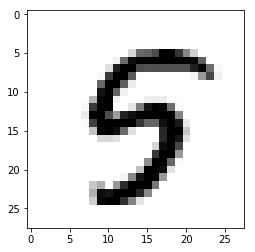

In [205]:
# show the first image
plt.imshow(images_X[7].reshape(28, 28), cmap=plt.cm.gray_r)

Looking good. Because the scikit-learn implementation of Restricted Boltzmann Machines will not allow for values outside of the range of 0-1, we will have to do a bit of preprocessing work.

### The BernoulliRBM

The only scikit-learn implemented version of a Restricted Boltzmann Machine is called BernoulliRBM because it imposes a constraint on the type of probability distribution it can learn. 

The Bernoulli distribution allows for data values to be between zero and one. The scikit-learn documentation states that the model assumes the inputs are either binary values or values between zero and one. This is done to represent the fact that the node values represent a probability that the node is activated or not.

It allows for quicker learning of feature sets. To account for this, we will alter our dataset to account for only hardcoded white/black pixel intensities. By doing so, every cell value will either be zero or one (white or black) to make learning more robust. We will accomplish this in two steps:

1.  We will scale the values of the pixels to be between zero and one
2.  We will change the pixel values in place to be true if the value is over 0.5, and false otherwise

Let's start by scaling the pixel values to be between 0 and 1:

In [206]:
# scale images_X to be between 0 and 1
image_X = images_X / 255

# make pixels binary (either white or black)
images_X = (images_X > 0.5).astype(float)

np.min(images_X), np.max(images_X)

(0.0, 1.0)

Let's take a look at the same number five digit, as we did previously, with our newly altered pixels:

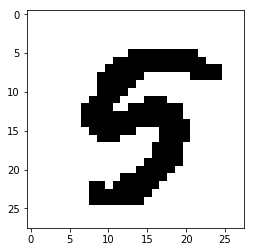

In [208]:
plt.imshow(images_X[7].reshape(28, 28), cmap=plt.cm.gray_r)

We can see that the fuzziness of the image has disappeared and we are left with a very crisp digit to classify with. Let's try now to extract features from our dataset of digits.

### Extracting PCA components from MNIST

Before we move to our RBM, let's take a look at what happens when we apply a PCA to our dataset. Like we did in the last chapter, we will take our features (784 pixels that are either on or off) and apply an eigenvalue decomposition to the matrix to extract eigendigits from the dataset.

Let's take 100 components from the possible 784 and plot the components to see what the extracted features look like. We will do this by importing our PCA module, fitting it to our data with 100 components, and creating a matplotlib gallery to display the top 100 components available to us:

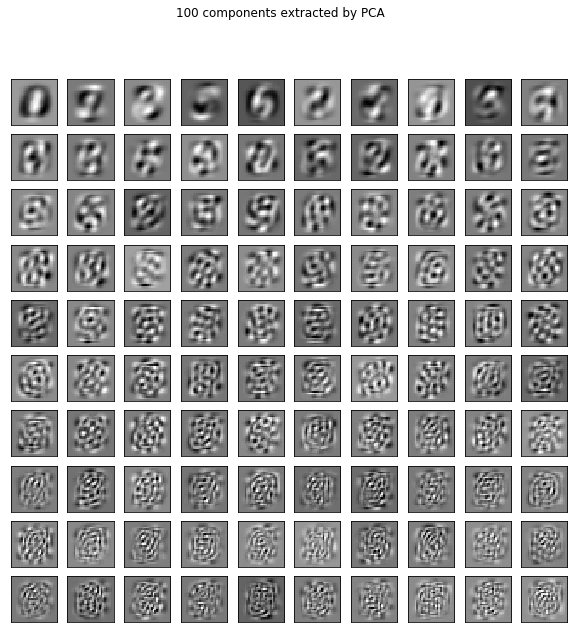

In [209]:
# import Principal Components Analysis module
from sklearn.decomposition import PCA

# extract 100 "eigen-digits"
pca = PCA(n_components=100) # 100x784
pca.fit(images_X)

# graph the 100 components
plt.figure(figsize=(10, 10))
for i, comp in enumerate(pca.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by PCA')

plt.show()

This gallery of images is showing us what the eigenvalues of the covariance matrix look like when reshaped to the same dimensions as the original images. This is an example of what extracted components look like when we focus our algorithms on a dataset of images. It is quite interesting to take a sneak peek into how the PCA components are attempting to grab linear transformations from the dataset. Each component is attempting to understand a certain "aspect" of the images that will translate into interpretable knowledge. For example, the first (and most important) eigen-image is likely capturing an images 0-quality that is, how like a 0 the digit looks.

It also is evident that the first ten components seem to retain some of the shape of the digits and after that, they appear to start devolving into what looks like nonsensical images. By the end of the gallery, we appear to be looking at random assortments of black and white pixels swirling around. This is probably because PCA (and also LDA) are parametric transformations and they are limited in the amount of information they can extract from complex datasets like images.

If we take a look to see how much variance the first 30 components are explaining, we would see that they are able to capture the majority of the information:

In [210]:
# first 30 components explain 64% of the variance
pca.explained_variance_ratio_[:30].sum()

0.6988671480395516

This tells us that the first few dozen components are doing a good job at capturing the essence of the data, but after that, the components are likely not adding too much.

This can be further seen in a scree plot showing us the cumulative explained variance for our PCA components:

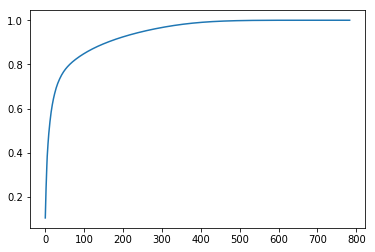

In [211]:
# Scree Plot

# extract all "eigen-digits"
full_pca = PCA(n_components=784)
full_pca.fit(images_X)

plt.plot(np.cumsum(full_pca.explained_variance_ratio_))
# 100 components captures about 90% of the variance

As we saw in the previous chapter, the transformations made by PCA are done through a single linear matrix operation by multiplying the components attribute of the PCA module with the data. We will show this again by taking the scikit-learn PCA object that we fit to 100 features and using it to transform a single MNIST image. We will take that transformed image and compare it the result of multiplying the original image with the components_ attribute of the PCA module:

In [212]:
# Use the pca object, that we have already fitted, to transform the first image in order to pull out the 100 new features
pca.transform(images_X[[7]]) # 1x100

array([[ 1.34620746e+00,  1.31981232e+00,  5.50776478e-01,
        -2.79624159e+00, -3.49388120e+00, -2.34700769e-01,
         9.79044262e-01, -1.07181018e-02,  2.07850019e+00,
         1.11435826e+00,  6.18991802e-01, -2.14979819e-01,
        -1.95503278e+00, -7.32508407e-01, -5.62287812e-01,
        -8.28556771e-01,  1.72649986e+00,  9.48100877e-01,
         5.90805985e-01, -2.01030059e-01, -5.01680141e-01,
         2.43512538e-01,  4.23995240e-01,  1.63144360e+00,
         1.18155803e+00,  3.55745550e-01, -4.95208199e-01,
        -1.28347900e+00,  4.86028882e-01,  3.71652008e-01,
        -2.51914631e-01,  1.47458085e-01,  9.72800961e-01,
         1.10127763e+00,  3.18466015e-01, -4.19366911e-02,
         3.55742009e-01,  2.22552508e-01, -1.11887049e-01,
         5.42449190e-01,  6.55331535e-01, -2.80131784e-01,
        -7.61884830e-01,  1.00061753e+00,  5.31645750e-01,
         1.68150565e-01,  2.05087733e-01, -3.69380380e-04,
         7.10072076e-02,  5.62896189e-04, -2.62270448e-0

In [213]:
# reminder that transformation is a matrix multiplication away
np.dot(images_X[[7]] - images_X.mean(axis=0), pca.components_.T) # 1x784 784x100 

array([[ 1.34620746e+00,  1.31981232e+00,  5.50776478e-01,
        -2.79624159e+00, -3.49388120e+00, -2.34700769e-01,
         9.79044262e-01, -1.07181018e-02,  2.07850019e+00,
         1.11435826e+00,  6.18991802e-01, -2.14979819e-01,
        -1.95503278e+00, -7.32508407e-01, -5.62287812e-01,
        -8.28556771e-01,  1.72649986e+00,  9.48100877e-01,
         5.90805985e-01, -2.01030059e-01, -5.01680141e-01,
         2.43512538e-01,  4.23995240e-01,  1.63144360e+00,
         1.18155803e+00,  3.55745550e-01, -4.95208199e-01,
        -1.28347900e+00,  4.86028882e-01,  3.71652008e-01,
        -2.51914631e-01,  1.47458085e-01,  9.72800961e-01,
         1.10127763e+00,  3.18466015e-01, -4.19366911e-02,
         3.55742009e-01,  2.22552508e-01, -1.11887049e-01,
         5.42449190e-01,  6.55331535e-01, -2.80131784e-01,
        -7.61884830e-01,  1.00061753e+00,  5.31645750e-01,
         1.68150565e-01,  2.05087733e-01, -3.69380380e-04,
         7.10072076e-02,  5.62896189e-04, -2.62270448e-0

## Extracting RBM components from MNIST

Let's now create our first RBM in scikit-learn. We will start by instantiating a module to extract 100 components from our MNIST dataset.

We will also set the verbose parameter to True to allow us visibility into the training process as well as the random_state parameter to 0. The random_state parameter is an integer that allows for reproducibility in code. It fixes the random number generator and sets the weights and biases randomly at the same time, every time. We finally let n_iter be 20. This is the number of iterations we wish to do, or back and forth passes of the network:

In [214]:
# instantiate our BernoulliRBM
# we set a random_staet to initialize our weights and biases to the same starting point
# verbose is set to True to see the fitting period
# n_iter is the number of back and fortth passes
# n_components (like PCA and LDA) represent the number of features to create
# n_components can be any integer, less than, equal to, or greater than the original number of features

rbm = BernoulliRBM(random_state=0, verbose=True, n_iter=20, n_components=100)
rbm.fit(images_X)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -153.56, time = 0.69s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -149.82, time = 0.80s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -141.17, time = 0.79s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -143.79, time = 0.80s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -128.13, time = 0.79s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -130.09, time = 0.79s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -131.48, time = 0.78s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -123.57, time = 0.80s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -137.29, time = 0.79s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -122.38, time = 0.79s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -127.95, time = 0.79s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -124.17, time = 0.79s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -130.52, time = 0.79s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -144.92, time = 0.79s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=20,
       random_state=0, verbose=True)

Once training is complete; we can explore the end result of the process. RBM also has a components module, like PCA does:

In [215]:
# RBM also has components_ attribute
len(rbm.components_)

100

We can also plot the RBM components that were learned by the module to see how they differ from our eigendigits:

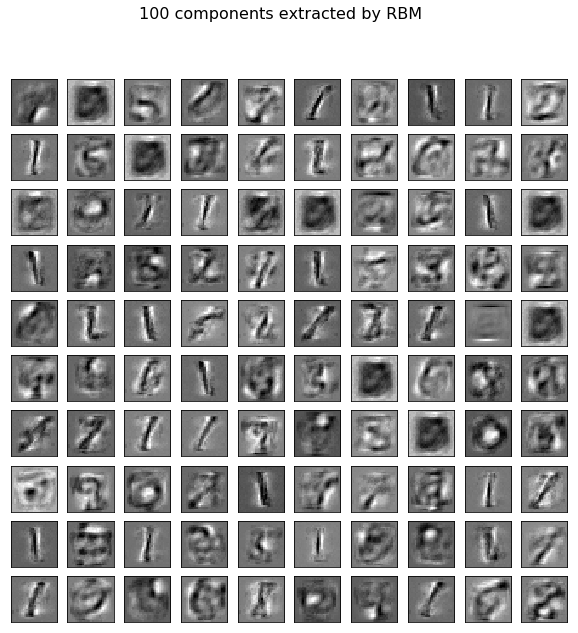

In [216]:
# plot the RBM components (representations of the new feature sets)
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i+1)
    plt.imshow(comp.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.show()

These features look very interesting. Where the PCA components became visual distortions after a while, the RBM components seem to be extracting various shapes and pen strokes with each component. At first glance, it looks like we have repeat features. We can do a quick NumPy check to see if any of the components are actually repeating, or if they are just very similar.

This code will check to see how many unique elements exist in rbm.components_. If the resulting shape has 100 elements in it, that means that every component of the RBM is in fact different:

In [217]:
# It looks like many of these components are exactly the same but
# this shows that all components are actually different (albiet some very slightly) from one another
np.unique(rbm.components_.mean(axis=1)).shape

(100,)

This validates that our components are all unique from one another. We can use the RBM to transform data like we can with PCA by utilizing the transform method within the module:

In [219]:
# Use our Boltzman Machine to transform a single image of a 5
image_new_features = rbm.transform(images_X[[7]]).reshape(100,)

image_new_features

array([1.85728078e-18, 1.00000000e+00, 1.00000000e+00, 4.32147017e-26,
       2.12316979e-11, 1.82326591e-14, 3.32178664e-14, 1.33424199e-13,
       1.03849255e-18, 1.00000000e+00, 5.53302253e-17, 2.24817982e-15,
       1.00000000e+00, 4.97650886e-09, 4.65892984e-08, 1.28861250e-21,
       6.02015673e-23, 1.00000000e+00, 1.28066308e-20, 9.49282861e-21,
       1.46244182e-06, 1.23802728e-15, 3.61290769e-16, 2.72758542e-18,
       9.84766618e-01, 1.00000000e+00, 3.38565887e-32, 2.08431136e-21,
       7.58338074e-16, 1.00000000e+00, 1.94710769e-06, 3.96218318e-27,
       9.39650718e-01, 1.57560805e-31, 1.79132533e-11, 1.54698674e-17,
       2.48162651e-25, 3.69255758e-01, 9.13884328e-09, 2.35714131e-07,
       5.59459946e-04, 2.81413180e-20, 2.77283724e-14, 8.06004509e-23,
       1.40448865e-16, 6.07805755e-19, 5.90957280e-22, 4.24666038e-17,
       1.64044890e-23, 1.00000000e+00, 1.20547763e-12, 4.03729496e-20,
       5.95914148e-17, 5.50318497e-12, 9.28581879e-01, 6.36922982e-04,
      

And we can also see that these components are <b>not</b> used in the same way as PCAs are, meaning that a simple matrix multiplication will not yield the same transformation as invoking the transform method embedded within the module:

In [220]:
# not the same as a simple matrix multiplication anymore
# uses neural architecture (several matrix operations) to transform features
np.dot(images_X[[7]] - images_X.mean(axis=0), rbm.components_.T)

array([[-1.71691668e+01,  5.97059037e+00,  5.83461895e+01,
        -2.86403158e+01,  8.70459270e+00, -1.39515440e+00,
        -1.95721970e+01, -4.91853729e+00, -5.53480349e+00,
         3.03832145e+01, -3.53634963e+00,  3.99006382e-01,
         5.95568522e+00, -4.76022095e+00, -2.94741480e+00,
        -1.19360927e+01, -1.86677240e+01,  4.73691044e+01,
        -1.32866253e+01, -1.44261287e+01,  5.33751469e+00,
         6.45252715e+00, -4.82076108e+00, -5.56029267e+00,
         8.82379916e+00,  6.08182392e+00, -4.46239689e+01,
        -3.02098270e+01, -3.42093906e+00,  6.23297011e+00,
        -7.28378251e-03, -2.19663913e+01,  3.89274439e+01,
        -3.49377658e+01, -1.39914303e+00, -5.79414479e+00,
        -3.79590526e+01,  1.34303489e+01, -1.40263410e+01,
         1.61832428e+01,  5.35930896e+00, -1.28692897e+01,
        -4.18647822e+00, -2.35415663e+01, -1.03744335e+01,
        -5.12863058e+00, -1.54124537e+01, -8.21797211e+00,
        -5.11313919e+01,  5.60184098e+00, -7.89551826e+0

Now that we know that we have 100 new features to work with and we've seen them, let's see how they interact with our data.

Let's start by grabbing the 20 most represented features for the first image in our dataset, the digit 5:

In [221]:
# get the most represented features
top_features = image_new_features.argsort()[-20:][::-1]
top_features

array([49, 29,  1, 12, 69, 56, 57, 67, 86, 25,  9, 17,  2, 98, 91, 24, 32,
       54, 93, 70], dtype=int64)

In [222]:
image_new_features[top_features]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999975,
       0.98476662, 0.93965072, 0.92858188, 0.90066538, 0.83803568])

In this case, we actually have 10 features in which the RBM has a full 100%. In our graph, this means that passing in these 784 pixels into our visible layers lights up nodes 49, 83, 16, 20, 95, 53, 75, 99, 29, and 24 at full capacity. Let's isolate these features:

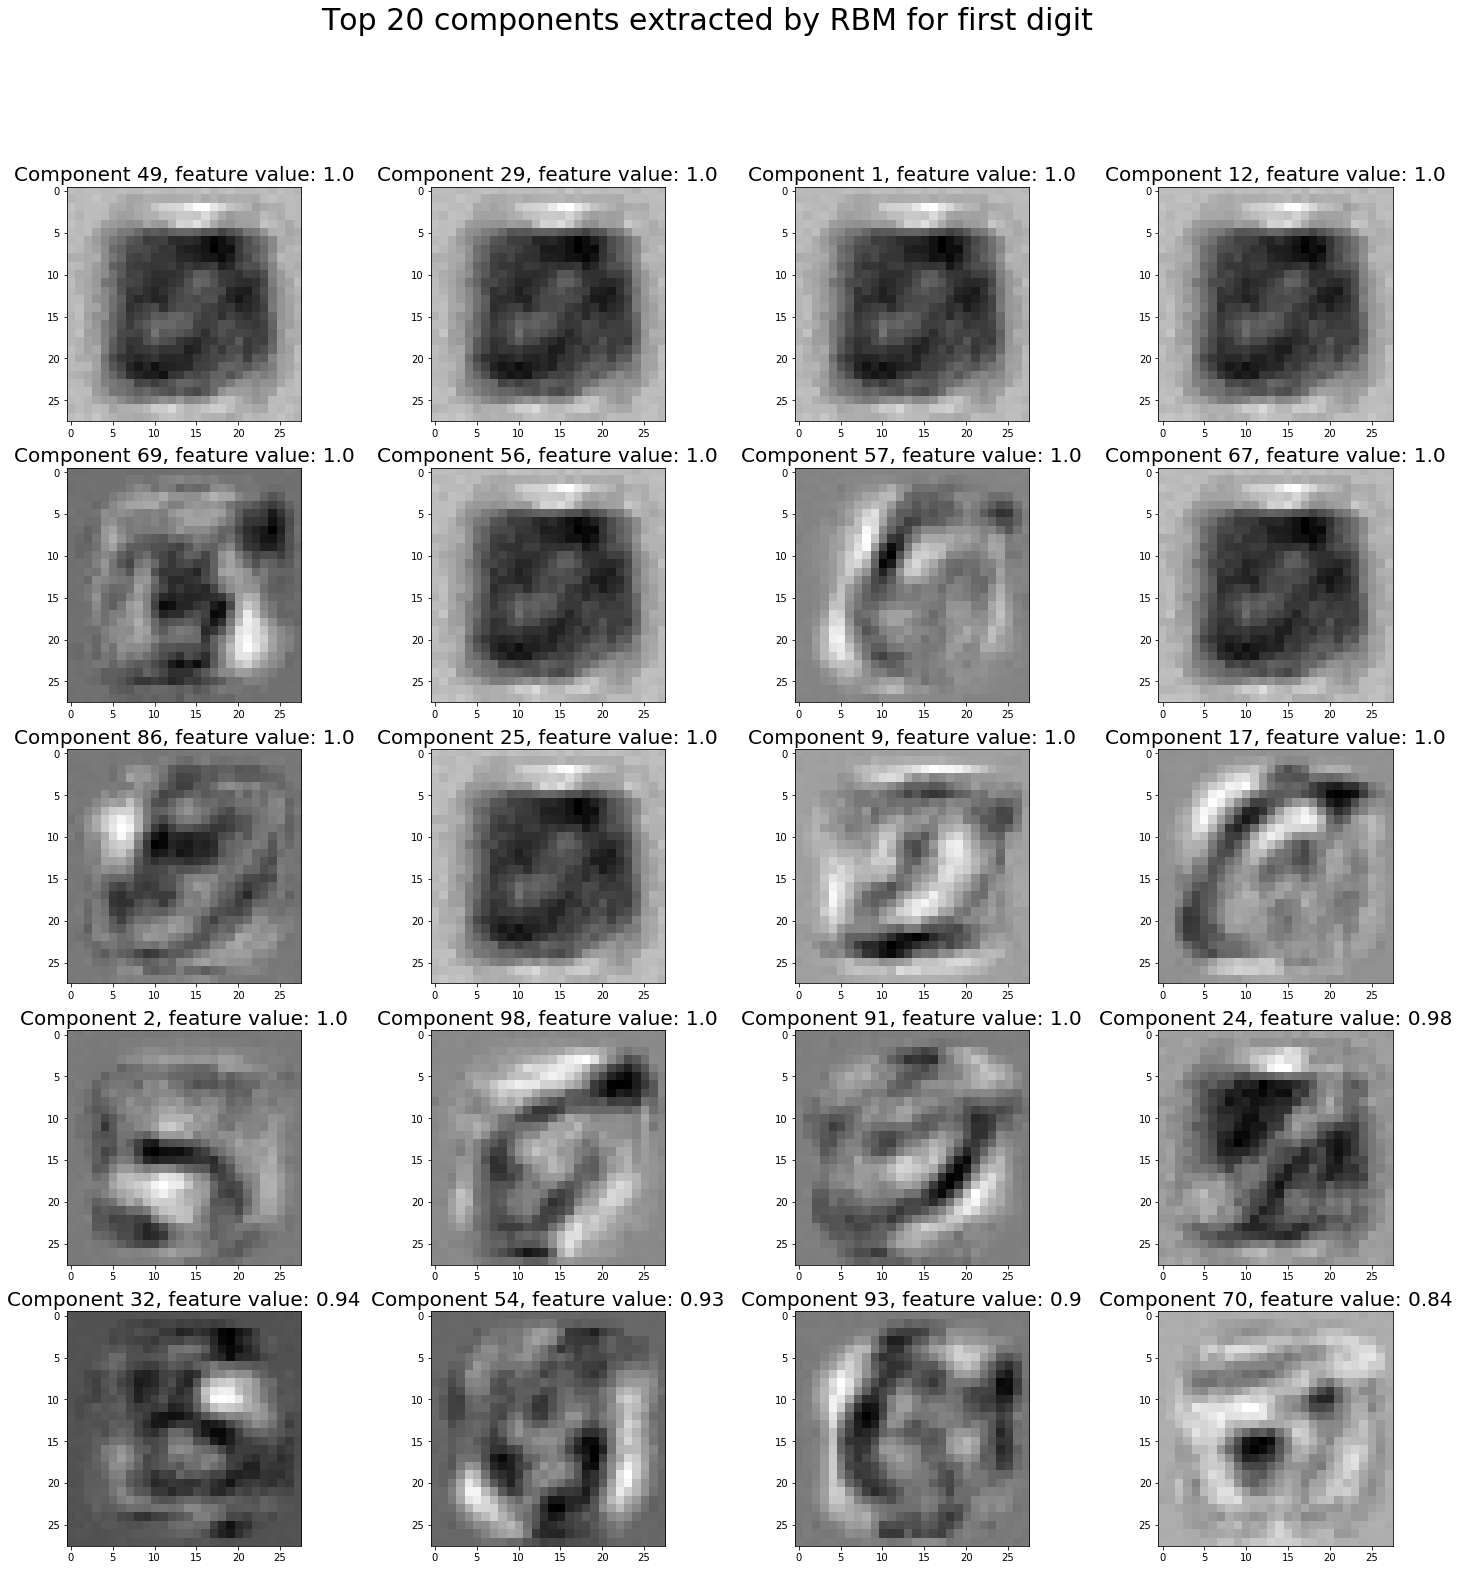

In [223]:
# plot the RBM components (representations of the new feature sets) for the most represented features
plt.figure(figsize=(25, 25))
for i, comp in enumerate(top_features):
    plt.subplot(5, 4, i+1)
    plt.imshow(rbm.components_[comp].reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.title("Component {}, feature value: {}".format(comp, round(image_new_features[comp], 2)),
             fontsize=20)
plt.suptitle("Top 20 components extracted by RBM for first digit", fontsize=30)
plt.show()

Taking a look at some of these, they make quite a lot of sense. Component 57 seems to isolate the top-left corner of the digit 5, while Component 2 seems to grab the bottom loop of the digit. Component 86 seem to grab almost an entire 5 in one go. Let's see what the bottom of the barrel looks like for the number 5 by isolating the bottom 20 features that lit up in the RBM graph when these pixels were passed through:

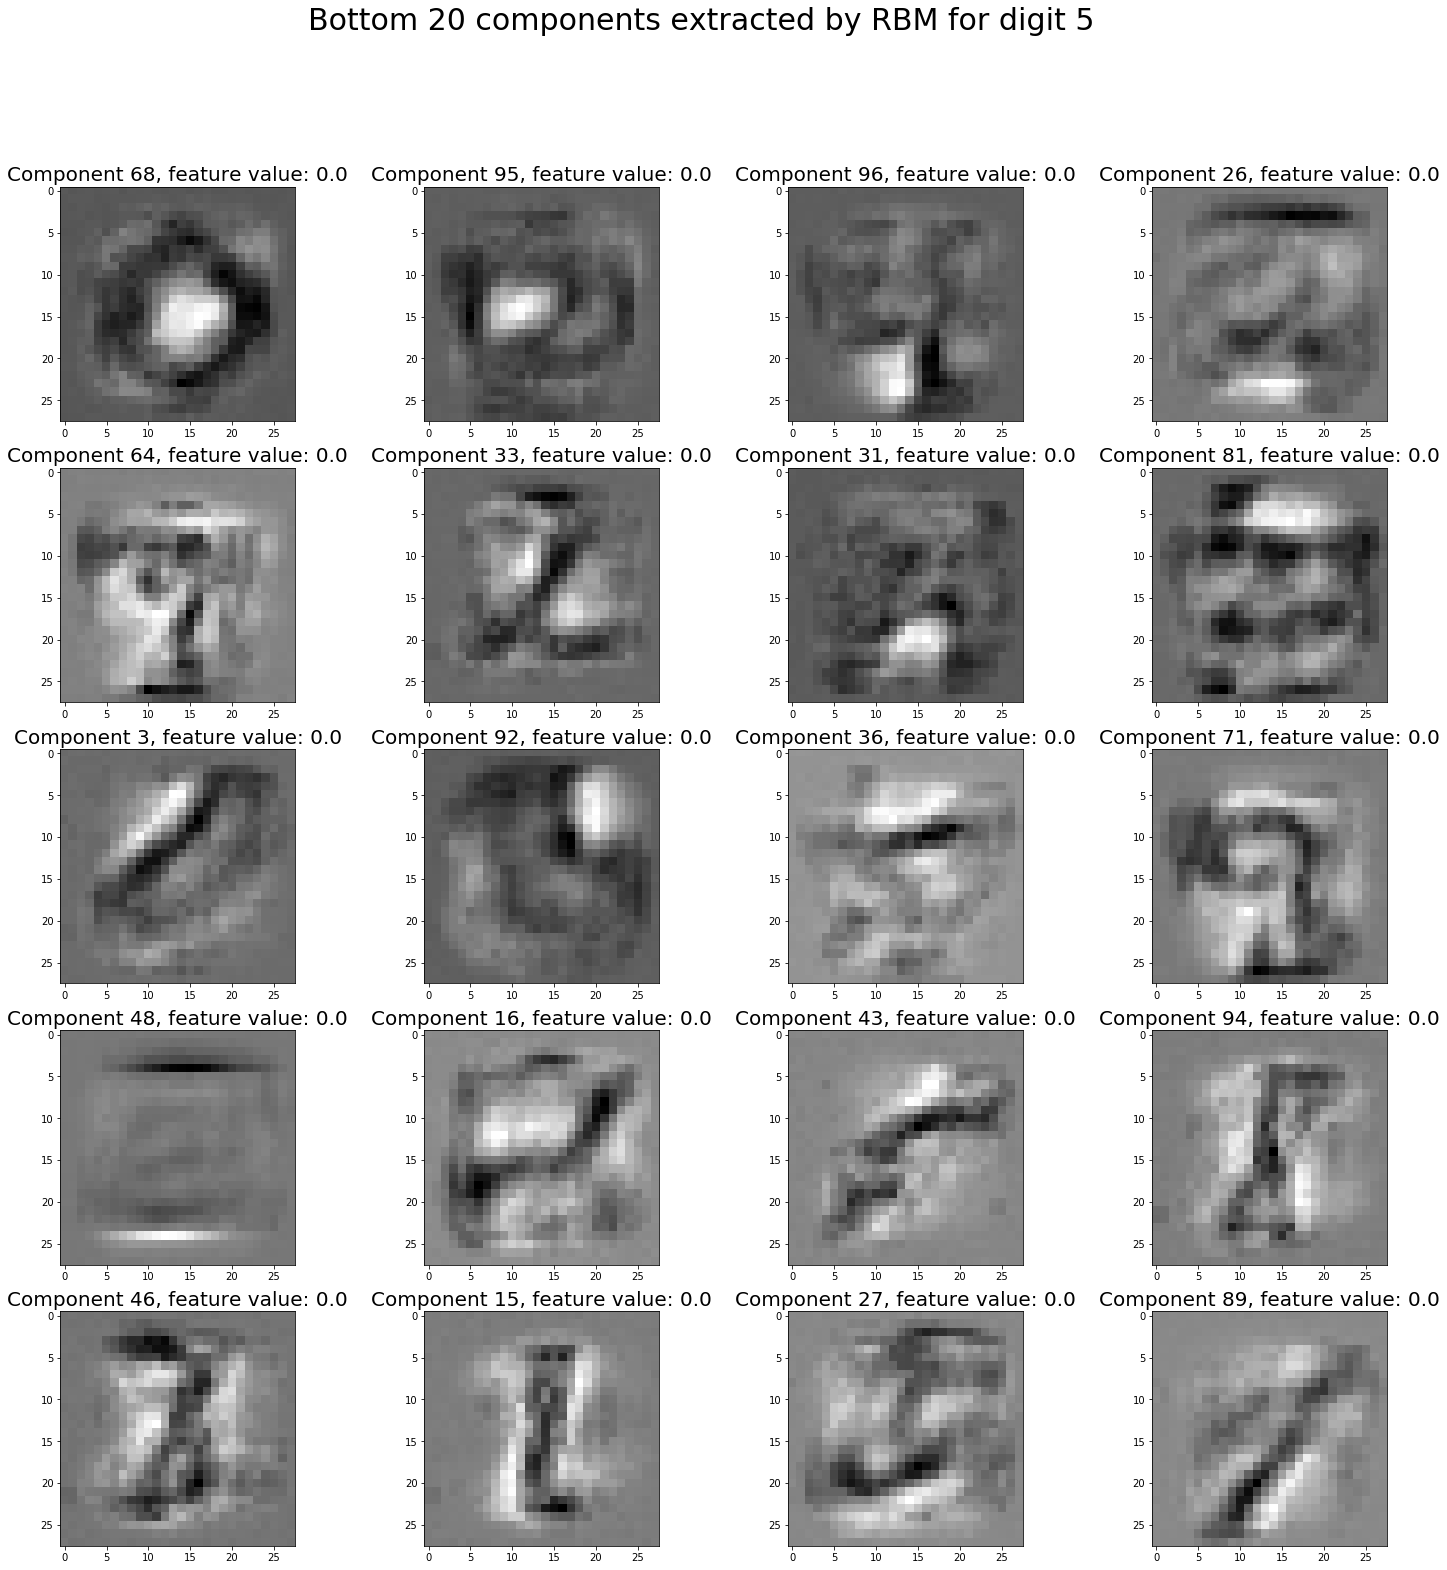

In [224]:
# grab the least represented features
bottom_features = image_new_features.argsort()[:20]

plt.figure(figsize=(25, 25))
for i, comp in enumerate(bottom_features):
    plt.subplot(5, 4, i + 1)
    plt.imshow(rbm.components_[comp].reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.title("Component {}, feature value: {}".format(comp, round(image_new_features[comp], 2)), fontsize=20)
plt.suptitle("Bottom 20 components extracted by RBM for digit 5", fontsize=30)
plt.show()

Component 68, Component 46, Component 3, and others seem to be trying to reveal different digits and not a 5, so it makes sense that these components are not being lit up by this combination of pixel strengths.

## Using RBMs in a machine learning pipeline

Of course, we want to see how the RBM performs in our machine learning pipelines to not just visualize the workings of the model, but to see concrete results of the feature learning. To do this, we will create and run three pipelines:

-  A logistic regression model by itself running on the raw pixel strengths
-  A logistic regression running on extracted PCA components
-  A logistic regression running on extracted RBM components

Each of these pipelines will be grid-searched across a number of components (for PCA and RBM) and the C parameter for logistic regression. Let's start with our simplest pipeline. We 
will run the raw pixel values through a logistic regression to see if the linear model is enough to separate out the digits.

## Using a linear model on raw pixel values

To begin, we will run the raw pixel values through a logistic regression model in order to obtain something of a baseline model. We want to see if utilizing PCA or RBM components will allow the same linear classifier to perform better or worse. If we can find that the extracted latent features are performing better (in terms of accuracy of our linear model) then we can be sure it is the feature engineering that we are employing that is enhancing our pipeline, and nothing else.

In [225]:
# import logistic regression and gridsearch module for some machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# create our Logistic Regression
lr = LogisticRegression()
params = {'C': [1e-2, 1e-1, 1e0, 1e1]}

# instantiate a gridsearch class
grid = GridSearchCV(lr, params)

Once we done this, we can fit our module to our raw image data. This will give us a rough idea of how the raw pixel data performs in a machine learning pipeline:

In [230]:
# fit to our data
grid.fit(images_X, images_y)

# check the best params
grid.best_params_,grid.best_score_

({'C': 0.1}, 0.8871774354870974)

Logistic regression by itself does a decent job at using the raw pixel values to identify digits by giving about an 88.72% cross-validated accuracy.

## Using a linear model on extracted PCA components

Let's see if we can add in a PCA component to the pipeline to enhance this accuracy. We will begin again by setting up our variables. This time we will need to create a scikit-learn pipeline object to house the PCA module as well as our linear model. We will keep the same parameters that we used for the linear classifier and add new parameters for our PCA. We will attempt to find the optimal number of components between 10, 100, and 200 components. Try to take a moment and hypothesize which of three will end up being the best (hint, think back to the scree plot and explained variance):

In [231]:
# Use PCA to extract new features

lr = LogisticRegression()
pca = PCA()

# set the params for the pipeline
params = {'clf__C': [1e-1, 1e0, 1e1],
         'pca__n_components': [10, 100, 200]}

# create our pipeline
pipeline = Pipeline([('pca', PCA()), ('clf', lr)])

# instantiate a gridsearch class
grid = GridSearchCV(pipeline, params)

We can now fit the gridsearch object to our raw image data. Note that the pipeline will take care of automatically extracting features from and transforming our raw pixel data:

In [232]:
# fit to our data
grid.fit(images_X, images_y)

# check the best params
grid.best_params_, grid.best_score_

({'clf__C': 0.1, 'pca__n_components': 200}, 0.883376675335067)

We end up with a (slightly lower) 88.34% cross-validated accuracy. If we think about it, we should not be surprised that 100 was the best option out of 10, 100, and 200. From our brief analysis with the scree plot in a previous section, we found that 69% of the data was explained by a mere 30 components, so 10 components would definitely not be enough to explain the images well. The scree plot also started to level out at around 100 components, meaning that after the 100th component, the explained variance was truly not adding much, so 200 was too many components to use and would have started to lead to some overfitting. That leaves us with 100 as being the optimal number of PCA components to use. It should be noted that we could go further and attempt some hyper-parameter tuning to find an even more optimal number of components, but for now we will leave our pipeline as is and move to using RBM components.

## Using a linear model on extracted RBM components

Even the optimal number of PCA components was unable to beat the logistic regression alone by much in terms of accuracy. Let's see how our RBM does. To make the following pipeline, we will keep the same parameters for the logistic regression model and find the optimal number of components between 10, 100, and 200 (like we did for the PCA pipeline). Note that we could try to expand the number of features past the number of raw pixels (784) but we will not attempt to.

We begin the same way by setting up our variables:

In [237]:
# Use the RBM to learn new features

rbm = BernoulliRBM(random_state=0)

# set up the params for our pipeline.
params = {'clf__C': [1e-1, 1e0, 1e1],
         'rbm__n_components': [10, 100, 200, 300, 400]
}

# create our pipeline
pipeline = Pipeline([('rbm', rbm), ('clf', lr)])

# instantiate a gridsearch class
grid = GridSearchCV(pipeline, params)

Fitting this grid search to our raw pixels will reveal the optimal number of components:

In [238]:
# fit to our data
grid.fit(images_X, images_y)

# check the best params
grid.best_params_, grid.best_score_

({'clf__C': 1.0, 'rbm__n_components': 400}, 0.913382676535307)

Our RBM module, with a 91.34% cross-validated accuracy, was able to extract 200 new features from our digits and give us a boost of three percent in accuracy (which is a lot!) by not doing anything other than adding the BernoulliRBM module into our pipeline.

*The fact that 200 was the optimal number of components suggests that we may even obtain a higher performance by trying to extract more than 200 components. We will leave this as an exercise to the reader.

This is evidence to the fact that feature learning algorithms work very well when dealing with very complex tasks such as image recognition, audio processing, and natural language processing. These large and interesting datasets have hidden components that are difficult for linear transformations like PCA or LDA to extract but non-parametric algorithms like RBM can.

In [235]:
# References and credits to
# Feature Engineering Made Easy